In [195]:
# default_exp ocrlearner_training_1
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# OCR Learner Training 1

Trianing simple OCR models for use with font optimiser.

In [1]:
#export

from aifont.core import *
from aifont.ocrlearner import *
import cornet
from fastai.data.all import *
from fastai.vision.all import *
from enum import Enum, auto
import gc
import hashlib
from itertools import product
from nbdev.showdoc import *
import matplotlib.pyplot as plt
import os
import pandas as pd
from pandas import DataFrame
import PIL
import random
import re
import scipy.io
import string
import torchvision.transforms.functional as VF
import torchvision.transforms as VT
from typing import Callable, List, Sequence, Tuple

NameError: name 'VectorRenderLayerBase' is not defined

## Model Architectures

## Create and load OCR Learners and models

In [208]:
#export

def list_params(learn: Learner) -> None:
    """Quickly list param groups and params to see which ones are frozen."""
    for i,g in enumerate(learn.opt.param_groups):
        for j,p in enumerate(g["params"]):
            print(f"Group {i} • Param {j}: {p.shape}, {'grad' if p.requires_grad else 'no grad'}")

def load_ocr_model(
    file: str = None, 
    arch: Callable = None, 
    df: Callable = None, 
    vocab: List[str] = VOCAB_UC,
    version: str = None,
    model_dir: str = MODELS_PATH, 
    n_out: int = None, 
    **kwargs
    ) -> Module:
    """Load a trained OCR model for use with `OCRLoss`. Pass either `file` and `arch` or
       `arch`, `df`, `version` and `vocab` to construct the filename automatically."""
    assert None not in (file, arch) or None not in (arch, df, vocab)
    if file is None: file = get_learner_filename(arch, df, vocab, version=version, incl_suffix=True)
    if n_out is None: n_out = len(vocab)
    file = os.path.join(model_dir, file)
    report(f"Loading OCR model: {file}")
    # This is awful, sry!
    model = arch(n_out=n_out, **kwargs)
    model = model[0] if type(model) is tuple else model
    load_model(file, model, opt=False, device=None)
    return model

def get_learner_filename(arch: Callable, df: Callable, 
    vocab: List[str] = None, 
    version: str = None,
    incl_suffix = False) -> str:
    """Create a filaneme for the model for use with saving and loading."""
    sfx = ".pth" if incl_suffix else ""
    vcb = f"__vocab_{hashlib.md5(''.join(vocab).encode('utf-8')).hexdigest()}" if vocab else ""
    ver = "" if version in (None, "") else f"_{version}"
    return f"{arch.__name__}__{df.__name__}{vcb}{ver}{sfx}"

def get_ocr_learner_2(
    arch=kaggle_cnn_a, 
    n_out=None, 
    bs=128, 
    df=get_a_z_handw_images, 
    vocab=VOCAB_UC,
    version=None,
    normalize=False, 
    load_saved=True, 
    size=28,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam, 
    init=nn.init.kaiming_normal_,
    lr=defaults.lr, 
    splitter=None, 
    use_xtra_tfms=False,
    cbs=None, 
    metrics=accuracy, 
    path=None, 
    model_dir=MODELS_PATH, 
    wd=None, 
    wd_bn_bias=False, 
    train_bn=True, 
    moms=(0.95,0.85,0.95), 
    **kwargs) -> Learner:
    """Create a new OCR learner based on architecture `arch` and dataset `df`.
       If `pretrained`, the model will be initialised if a suitable save is found."""
    if use_xtra_tfms:
        max_rotate = 15.0
        max_warp = .25
        blur = GaussianBlur(p=.5, random_size=5)
        noise = Noise(p=.5, f=(0., .6))
        item_tfms = [blur, noise]
    else: 
        max_rotate = 5.0
        max_warp = .1
        item_tfms = None
    tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                          min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=.5, 
                          p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                          pad_mode='reflection', align_corners=True, batch=False, 
                          min_scale=1.0)
    del(tfms[1]) # Remove lighting tfm
    warn("Need to add custom normalisation scheme and check this doesn't expand channels!")
    # See: Normalize.from_stats(mean,std) https://docs.fast.ai/data.transforms.html#Normalize
    dls = ImageDataLoadersDF.from_df(df(), vocab=vocab,
                                     width=size, height=size,
                                     num_workers=0, # Needed for Mac
                                     valid_pct=0.2, 
                                     batch_tfms=tfms,
                                     item_tfms=item_tfms,
                                     seed=42, bs=bs)

    if n_out is None: n_out = get_c(dls)
    # This is a crappy, but we can specify the splitter in arch
    model_and_splitter = arch(n_out, input_shape=(size, size))
    if type(model_and_splitter) is tuple:
        model, splitter = model_and_splitter
    else: 
        model = model_and_splitter
        splitter = lambda m: L(m[0], m[1:]).map(params)
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, 
                    splitter=splitter, cbs=cbs,  metrics=metrics, path=path, model_dir=model_dir, 
                    wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    if load_saved: learn.load(get_learner_filename(arch=arch, df=df, vocab=vocab, version=version))
    store_attr('arch,normalize,n_out', self=learn, **kwargs)
    return learn

def get_ocr_learner_3(
    arch=kaggle_cnn_a, 
    n_out=None, 
    bs=128, 
    df=get_combined_az_and_tmnist_df, 
    start_col=1,
    vocab=VOCAB_UC,
    version=None,
    normalize=False, 
    load_saved=True, 
    size=28,
    loss_func=CrossEntropyLossFlat(), 
    opt_func=Adam, 
    init=nn.init.kaiming_normal_,
    lr=defaults.lr, 
    splitter=None, 
    use_xtra_tfms=False,
    tfms_p=.5,
    blur_size: Tuple[int, Sequence[int]]=5,
    blur_sigma: Tuple[int, Sequence[int]]=(.1, 5.), 
    cbs=None, 
    metrics=accuracy, 
    path=None, 
    model_dir=MODELS_PATH, 
    wd=None, 
    wd_bn_bias=False, 
    train_bn=True, 
    moms=(0.95,0.85,0.95),
    seed=None,
    **kwargs) -> Learner:
    """Create a new OCR learner based on architecture `arch` and dataset `df`.
       If `pretrained`, the model will be initialised if a suitable save is found."""
    tfms = []
    item_tfms = []
    # Check if we need to pad
    data = df()
    orig_sz = math.isqrt(data.shape[1] - start_col)
    if orig_sz < size: 
        pad = (size - orig_sz) // 2
        assert orig_sz + 2 * pad == size
        item_tfms += [Pad(pad, fill=255)]
    if normalize: tfms += [get_imagenet_norm()] # ToRGB(), 
    if use_xtra_tfms:
        max_rotate = 15.0
        max_warp = .25
        blur = GaussianBlur(p=tfms_p, random_size=blur_size, sigma=blur_sigma)
        noise = Noise(p=tfms_p, f=(0., .6))
        item_tfms += [blur, noise]
    else: 
        max_rotate = 5.0
        max_warp = .1
    aug_tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=max_rotate, 
                          min_zoom=0.85, max_zoom=1.15, max_warp=max_warp, p_affine=tfms_p, 
                          p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                          pad_mode='reflection', align_corners=True, batch=False, 
                          min_scale=1.0)
    del(aug_tfms[1]) # Remove lighting tfm

    tfms += aug_tfms
    dls = ImageDataLoadersDF.from_df(data, vocab=vocab,
                                     width=orig_sz, height=orig_sz,
                                     num_workers=0, # Needed for Mac
                                     valid_pct=0.2, 
                                     batch_tfms=tfms,
                                     item_tfms=item_tfms,
                                     color=normalize,
                                     seed=seed, bs=bs)
    if n_out is None: n_out = get_c(dls)
    # This is a crappy, but we can specify the splitter in arch
    model_and_splitter = arch(n_out, input_shape=(size, size))
    if type(model_and_splitter) is tuple:
        model,splitter = model_and_splitter
    else: 
        model = model_and_splitter
        splitter = lambda m: L(m[0], m[1:]).map(params)
    learn = Learner(dls=dls, model=model, loss_func=loss_func, opt_func=opt_func, lr=lr, 
                    splitter=splitter, cbs=cbs,  metrics=metrics, path=path, model_dir=model_dir, 
                    wd=wd, wd_bn_bias=wd_bn_bias, train_bn=train_bn, moms=moms)
    if load_saved: learn.load(get_learner_filename(arch=arch, df=df, vocab=vocab, version=version))
    store_attr('arch,normalize,n_out', self=learn, **kwargs)
    return learn

## Training the Models

> Do not autorun below this, as it will commence training.

### Training CorNET with the Full Dataset and Severe Augmenations

Inspired by the success of the full-dataset model, let's train it further with the same, severe blur we're using in the font optimisation pipeline (see notebook 12) and a higher proportion of augmentations.

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,accuracy,time
0,1.232312,0.670324,0.988785,1:10:29
1,1.172647,0.701468,0.984290,1:52:07
2,1.151835,0.715169,0.981920,55:34
3,1.102665,0.707120,0.982166,1:32:23
4,1.088409,0.701276,0.981875,52:30
5,1.064032,0.701814,0.983664,52:23
6,1.043089,0.689597,0.983261,52:19
7,1.032109,0.686046,0.984782,52:23
8,1.017871,0.679885,0.985565,52:37
9,1.016628,0.678393,0.985811,52:20


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur_ep10.pth')

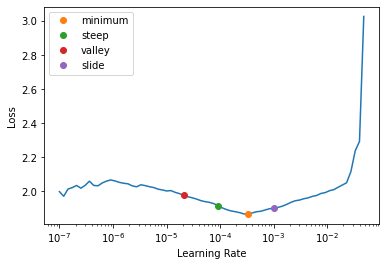

In [12]:
learn = None; gc.collect()
args = dict(arch=cornet_for_ocr, 
            df=partial(get_combined_az_and_tmnist_df, False))
base_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds"
learn_fn = f"{base_fn}_blur"
learn = get_ocr_learner_3(**args,
                            use_xtra_tfms=True, 
                            tfms_p=.8,
                            blur_size=(9, 15),
                            blur_sigma=(3., 5.), 
                            size=48, 
                            normalize=True,
                            load_saved=False,
                            bs=256)
learn.load(base_fn)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)
learn.fit_one_cycle(10, lrs.slide)
learn.save(f"{learn_fn}_ep10")

The training loss looks like it might still go down, so let's train further.

In [13]:
learn.fit_one_cycle(10, lrs.slide)
learn.save(f"{learn_fn}_ep20")

epoch,train_loss,valid_loss,accuracy,time
0,1.029303,0.689228,0.984939,58:48
1,1.070492,0.710362,0.981461,1:00:19
2,1.081075,0.715442,0.978397,1:51:08
3,1.071163,0.703051,0.981942,1:02:54
4,1.055097,0.705503,0.981383,1:44:08
5,1.031040,0.693314,0.983027,3:33:53
6,1.017131,0.688600,0.984111,2:06:50
7,0.996041,0.682793,0.984827,56:01
8,0.987833,0.678232,0.985498,53:06
9,0.994388,0.677198,0.985878,52:39


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur_ep20.pth')

There might still be room for improvement. Let's see.

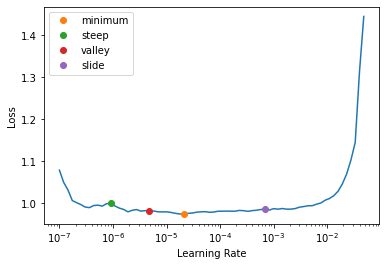

In [14]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=True)

In [15]:
learn.fit_one_cycle(10, 1e-4)
learn.save(f"{learn_fn}_ep30")

epoch,train_loss,valid_loss,accuracy,time
0,0.986214,0.677129,0.985945,1:18:40
1,0.985756,0.678469,0.985542,1:19:57
2,0.983248,0.677243,0.985777,1:04:08
3,0.992181,0.677371,0.985542,1:31:00
4,0.985921,0.676954,0.985900,8:43:35
5,0.979848,0.675712,0.986258,53:27
6,0.983181,0.675143,0.986336,53:16
7,0.980004,0.674524,0.986157,52:41
8,0.980921,0.674541,0.986269,52:41
9,0.988607,0.674363,0.986269,52:43


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_blur_ep30.pth')

Okay, that seems to be the where it converges.

### Training CorNET with the Full Dataset

Let's train the model with the full dataset without balancing the categories, as this would reflect the letters' different real-world frequencies. We'll use fewer epochs to reflect the bigger dataset.

> This turned out to be the best-performing model in terms of OCR loss, regardless of the imbalanced categories.

In [12]:
learn = None; gc.collect()
args = dict(arch=cornet_for_ocr, 
            df=partial(get_combined_az_and_tmnist_df, False))
learn_fn = "cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds"
learn = get_ocr_learner_3(**args,
                            use_xtra_tfms=True, 
                            size=48, 
                            normalize=True,
                            load_saved=False,
                            bs=256)
# lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False)
# learn.fit_one_cycle(5, lrs.valley)
# learn.save(f"{learn_fn}_ep5")
learn.load(f"{learn_fn}_ep5")
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False)
learn.fit_one_cycle(10, lrs.slide)
learn.save(f"{learn_fn}_ep15")

/Users/kallejarvenpaa/opt/miniconda3/envs/ai-font-p3.9/lib/python3.9/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,accuracy,time
0,0.693006,0.666721,0.988181,1:00:43
1,0.704978,0.672551,0.987141,1:00:57
2,0.703172,0.673531,0.987108,59:56
3,0.699107,0.671105,0.987264,2:09:53
4,0.690743,0.669478,0.987018,54:56
5,0.688976,0.662986,0.989098,1:27:27
6,0.680508,0.659670,0.989646,48:59
7,0.677605,0.656609,0.990496,48:20
8,0.676568,0.654593,0.990775,48:18
9,0.673510,0.654190,0.990988,48:10


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_sz48_fullds_ep15.pth')

### Training Iterations of CORnet

Let's train a few iterations of the same model as below to see if there are any differences.

In [52]:
start_i = 6
training_log = {}
# def save_log(name = "_", *args) -> None:
#     if name not in training_log: training_log[name] = []
#     training_log[name].append(args if len(args) > 1 else args[0])

for i in range(start_i, 6):
    v = f"aug_sz48_iter{i}"
    print(f"Starting iter {v}")
    learn = None; gc.collect()
    args = dict(arch=cornet_for_ocr, 
                df=get_combined_az_and_tmnist_df)
    learn_fn = get_learner_filename(**args, version=v)
    learn = get_ocr_learner_3(**args,
                              use_xtra_tfms=True, 
                              size=48, 
                              normalize=True,
                              load_saved=False,
                              bs=256)
    # learn.logger = partial(save_log, v) # Did not work for some reason
    # if i == 3: learn.load("cornet_for_ocr__get_combined_az_and_tmnist_df_aug_iter3_ep5")
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False)
    with learn.no_logging(): learn.fit_one_cycle(5, lrs.valley)
    learn.save(f"{learn_fn}_ep5")
    training_log[v] = [learn.recorder.final_record]
    lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide), show_plot=False)
    with learn.no_logging(): learn.fit_one_cycle(20, lrs.slide)
    learn.save(f"{learn_fn}_ep25")
    training_log[v] += [learn.recorder.final_record]
    dump(training_log, "models/cornet_for_ocr_training_log")
    print(f"{training_log[v][-1][-1] * 100}%")

Starting iter aug_sz48_iter2


/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3270/433064654.py:57: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


98.14935326576233%
Starting iter aug_sz48_iter3


/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3270/433064654.py:57: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


98.5508382320404%
Starting iter aug_sz48_iter4


/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3270/433064654.py:57: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


98.43612313270569%
Starting iter aug_sz48_iter5


/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_3270/433064654.py:57: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


98.01170229911804%


### Augmented CORnet: First Iteration

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_27685/433064654.py:57: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


SuggestedLRs(minimum=0.13182567358016967, steep=0.00015848931798245758, valley=0.005248074419796467, slide=0.033113110810518265)

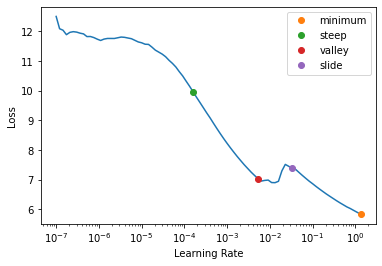

In [379]:
learn = None; gc.collect()
args = dict(arch=cornet_for_ocr, 
            df=get_combined_az_and_tmnist_df)
learn_fn = get_learner_filename(**args, version="aug")
learn = get_ocr_learner_3(**args,
                          use_xtra_tfms=True, 
                          size=48, 
                          normalize=True,
                          load_saved=False,
                          bs=256)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [380]:
learn.fit_one_cycle(5, lrs.valley)
learn.save(f"{learn_fn}_ep5")

epoch,train_loss,valid_loss,accuracy,time
0,1.083749,0.922579,0.937636,15:28
1,0.936820,0.822685,0.951898,15:33
2,0.850900,0.767840,0.964975,15:24
3,0.792460,0.719332,0.973464,15:34
4,0.759481,0.702814,0.976676,14:17


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_ep5.pth')

SuggestedLRs(minimum=5.754399353463669e-07, steep=7.585775847473997e-07, valley=2.2908675418875646e-06, slide=0.0010000000474974513)

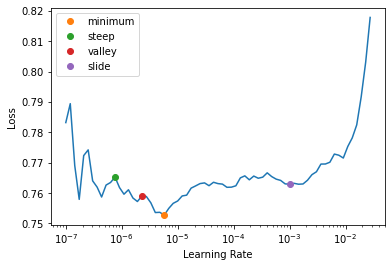

In [381]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [382]:
lr = lrs.slide
learn.fit_one_cycle(10, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep15")

epoch,train_loss,valid_loss,accuracy,time
0,0.764275,0.704266,0.976599,13:57
1,0.770933,0.708317,0.976599,13:57
2,0.767738,0.710701,0.975949,13:57
3,0.762034,0.708666,0.975682,13:58
4,0.752804,0.701386,0.978090,13:54
5,0.741536,0.694953,0.979773,13:56
6,0.738891,0.690866,0.980308,14:00
7,0.732327,0.687791,0.980691,14:02
8,0.727856,0.686396,0.981302,13:59
9,0.728199,0.685276,0.981302,13:59


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_ep15.pth')

SuggestedLRs(minimum=1.584893179824576e-05, steep=2.2908675418875646e-06, valley=3.0199516913853586e-05, slide=0.0010000000474974513)

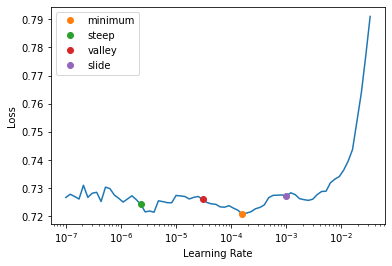

In [383]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [384]:
lr = lrs.slide
learn.fit_one_cycle(20, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep35")

epoch,train_loss,valid_loss,accuracy,time
0,0.729567,0.686354,0.981149,14:04
1,0.731308,0.688575,0.980423,14:01
2,0.742931,0.699660,0.977899,14:00
3,0.746527,0.699617,0.977517,14:01
4,0.745133,0.701001,0.977632,14:03
5,0.746833,0.700439,0.977632,14:04
6,0.748420,0.700990,0.978358,14:07
7,0.743903,0.695312,0.978473,14:05
8,0.740839,0.699731,0.976905,14:02
9,0.732916,0.690035,0.980614,13:57


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_ep35.pth')

SuggestedLRs(minimum=6.309573450380412e-08, steep=3.981071586167673e-06, valley=0.0002290867705596611, slide=0.0008317637839354575)

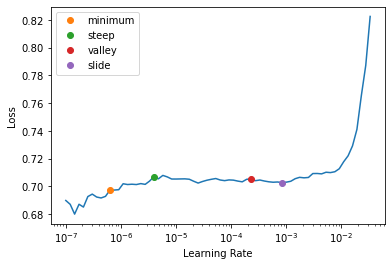

In [385]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [386]:
lr = lrs.slide
learn.fit_one_cycle(25, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep60")

epoch,train_loss,valid_loss,accuracy,time
0,0.706638,0.674847,0.984208,17:43
1,0.708647,0.676703,0.983597,16:02
2,0.717843,0.681373,0.982717,17:31
3,0.723619,0.687108,0.981149,18:10
4,0.724996,0.685133,0.982067,16:50
5,0.730548,0.687718,0.981532,15:18
6,0.732200,0.692715,0.979123,1:03:13
7,0.732170,0.689958,0.980691,42:57
8,0.726086,0.687381,0.980538,15:19
9,0.726064,0.681939,0.982908,1:47:31


Path('models/cornet_for_ocr__get_combined_az_and_tmnist_df_aug_ep60.pth')

### Augmented very simple CNN with skip connection with A–Z and TMNIST

Let's now try to train the model below with extra augmentations: blur, noise and rotations.

/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_42706/2270344933.py:73: UserWarning: Need to add custom normalisation scheme and check this doesn't expand channels!
  warn("Need to add custom normalisation scheme and check this doesn't expand channels!")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_42706/3304883756.py:33: UserWarning: Undersampled to max 2240 items / category, using 56043 items of 372450.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")
/var/folders/3p/10hbv0415234v3x5ctp50l4m0000gn/T/ipykernel_42706/3304883756.py:33: UserWarning: Undersampled to max 4311 items / category, using 74724 items of 74724.
  warn(f"Undersampled to max {n_min} items / category, using {len(df)} items of {tot}.")


SuggestedLRs(minimum=0.0007585775572806596, steep=9.12010818865383e-07, valley=0.0003311311302240938, slide=0.0006918309954926372)

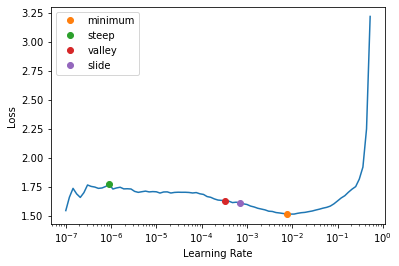

In [29]:
learn = None; gc.collect()
args = dict(arch=kaggle_cnn_a_with_res, df=get_combined_az_and_tmnist_df)
learn_fn = get_learner_filename(**args, version="aug")
learn = get_ocr_learner_2(**args,
                          use_xtra_tfms=True, # Use extras
                          bs=128)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [30]:
learn.fit_one_cycle(5, lrs.valley)
learn.save(f"{learn_fn}_ep5")

epoch,train_loss,valid_loss,accuracy,time
0,0.897906,0.724192,0.984055,43:44
1,0.843650,0.710722,0.984094,11:19
2,0.818181,0.707265,0.984782,11:09
3,0.817351,0.704900,0.984897,11:01
4,0.814272,0.702441,0.984897,11:00


Path('models/kaggle_cnn_a_with_res__get_combined_az_and_tmnist_df_aug_ep5.pth')

SuggestedLRs(minimum=9.120108734350651e-06, steep=1.3182567499825382e-06, valley=0.0004786300996784121, slide=0.0010000000474974513)

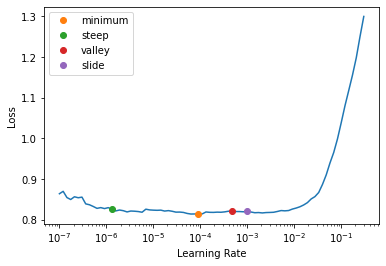

In [31]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [32]:
lr = lrs.slide
learn.fit_one_cycle(10, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep15")

epoch,train_loss,valid_loss,accuracy,time
0,0.829567,0.709552,0.983138,21:47
1,0.828708,0.716514,0.982602,10:16
2,0.824481,0.721540,0.981761,09:57
3,0.813283,0.716303,0.982717,10:04
4,0.814052,0.721317,0.981914,09:55
5,0.787556,0.706622,0.983711,10:00
6,0.785576,0.699826,0.984247,09:59
7,0.776272,0.696765,0.984629,09:58
8,0.777319,0.695039,0.984782,09:59
9,0.769778,0.694118,0.985088,09:56


Path('models/kaggle_cnn_a_with_res__get_combined_az_and_tmnist_df_aug_ep15.pth')

SuggestedLRs(minimum=6.30957365501672e-06, steep=5.248074739938602e-05, valley=0.0005754399462603033, slide=0.0012022644514217973)

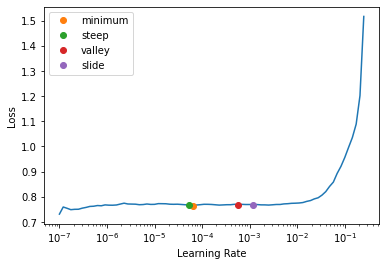

In [33]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [34]:
lr = lrs.slide
learn.fit_one_cycle(20, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep35")

epoch,train_loss,valid_loss,accuracy,time
0,0.773541,0.695893,0.984897,09:59
1,0.779177,0.698127,0.984591,10:01
2,0.789926,0.709704,0.984170,09:57
3,0.799184,0.715347,0.983176,09:57
4,0.797481,0.711481,0.983023,10:01
5,0.793831,0.706244,0.984094,09:58
6,0.786947,0.705967,0.982717,09:58
7,0.784185,0.731831,0.981685,09:57
8,0.773965,0.728961,0.980805,10:02
9,0.781666,0.789515,0.971590,09:59


Path('models/kaggle_cnn_a_with_res__get_combined_az_and_tmnist_df_aug_ep35.pth')

SuggestedLRs(minimum=1.737800812406931e-06, steep=9.12010818865383e-07, valley=3.981071586167673e-06, slide=0.0020892962347716093)

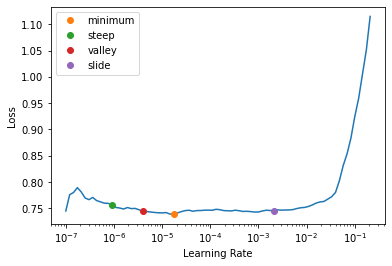

In [35]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

We could still out some improvements for the training loss in the previous bout of training, but the loss increased until the 10th epoch, so it seems a lower learning rate would be better.

In [36]:
lr = 2e-4 #lrs.slide
learn.fit_one_cycle(50, lr) # lr_max=slice(lr/10, lr)
learn.save(f"{learn_fn}_ep85")

epoch,train_loss,valid_loss,accuracy,time
0,0.745540,0.685110,0.985738,11:51
1,0.744133,0.684853,0.985585,11:38
2,0.743686,0.684762,0.985852,11:52
3,0.745938,0.684878,0.985585,12:12
4,0.744153,0.684989,0.985470,12:02
5,0.744060,0.685271,0.985317,11:17
6,0.743407,0.687045,0.985279,12:43
7,0.743560,0.685437,0.985776,12:10
8,0.749588,0.686526,0.986005,12:11
9,0.743925,0.685846,0.985814,12:26


Path('models/kaggle_cnn_a_with_res__get_combined_az_and_tmnist_df_aug_ep85.pth')

### Very simple CNN with skip connection with A–Z and TMNIST

Let's finally try to add residual connections to an otherwise very simple CNN. We get a very similar accuracy to the baseline one, 0.987114 after 15 epochs, but we are more interested in the smoothness of the predictions, of course.

WARNING! Need to add custom normalisation scheme and check this doesn't expand channels!
WARNING! Undersampled to max 2240 items / category, using 56043 items of 372450.
WARNING! Undersampled to max 4311 items / category, using 74724 items of 74724.


SuggestedLRs(minimum=0.03630780577659607, steep=0.002511886414140463, valley=0.0006918309954926372, slide=0.009120108559727669)

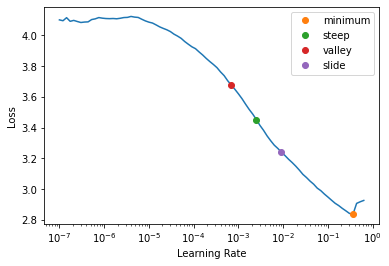

In [69]:
learn = None; gc.collect()
learn = get_ocr_learner_2(arch=kaggle_cnn_a_with_res, bs=128, df=get_combined_az_and_tmnist_df)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [71]:
count_params(learn.model)

832922

Let's train the model using the same suggest LR type as for the non-Res model.

In [73]:
learn.fit_one_cycle(5, lrs.valley)
learn.save("AZ_TMNIST_KaggleASkip_ep5")

Path('models/AZ_TMNIST_KaggleASkip_ep5.pth')

The accuracy is very similar to the version without a skip connection. Let's train a bit more.

SuggestedLRs(minimum=6.309573450380412e-08, steep=1.2022644114040304e-05, valley=0.0003981071640737355, slide=0.0008317637839354575)

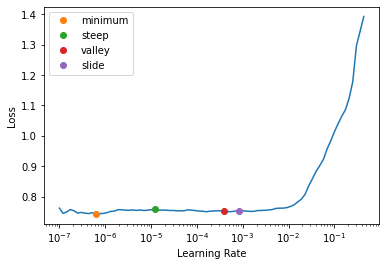

In [74]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

Let's train a bit. This time we don't bother with the slice.

In [75]:
lr = lrs.slide
learn.fit_one_cycle(10, lr) # lr_max=slice(lr/10, lr)
learn.save("AZ_TMNIST_KaggleASkip_ep15")

epoch,train_loss,valid_loss,accuracy,time
0,0.752015,0.733117,0.979276,10:52
1,0.754821,0.732697,0.977402,10:50
2,0.743354,0.718717,0.981188,10:42
3,0.731470,0.710342,0.983291,10:17
4,0.715429,0.710938,0.984247,10:04
5,0.708392,0.697737,0.985317,10:18
6,0.700707,0.695120,0.986464,10:12
7,0.695938,0.687887,0.987229,10:09
8,0.690961,0.686370,0.987000,09:50
9,0.687047,0.686307,0.987114,09:24


Path('models/AZ_TMNIST_KaggleASkip_ep15.pth')

### Kaggle CNN A with A–Z and TMNIST

Let's try the same Kaggle learner A as below, with the bigger dataset of handwritten and font glyphs. Accuracy 0.980767 after 20 epochs, which might still be improved.

WARN! Need to add custom normalisation scheme and check this doesn't expand channels!
WARNING! Undersampled to max 2240 items / category, using 56043 items of 372450.
WARNING! Undersampled to max 4311 items / category, using 74724 items of 74724.


SuggestedLRs(minimum=0.04365158379077912, steep=0.001737800776027143, valley=0.0006918309954926372, slide=0.02290867641568184)

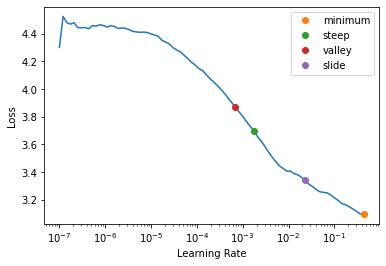

In [417]:
learn = None; gc.collect()
learn = get_ocr_learner_2(bs=128, df=get_combined_az_and_tmnist_df)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [429]:
learn.fit_one_cycle(5, lrs.valley)
learn.save("AZ_TMNIST_KaggleA_Adam_ep5")

epoch,train_loss,valid_loss,accuracy,time
0,1.140398,0.985390,0.922533,06:08
1,0.920577,0.846004,0.956487,06:02
2,0.855568,0.795332,0.968493,05:57
3,0.825790,0.774382,0.972967,06:01
4,0.809739,0.769602,0.973081,05:30


Path('models/AZ_TMNIST_KaggleA_Adam_ep5.pth')

The accuracy is very high, which might partly be due to the assumedly easier-to-categorize font glyphs being overrepresented in the dataset. Let's still train it a bit further.

SuggestedLRs(minimum=8.31763736641733e-07, steep=6.309573450380412e-07, valley=3.630780702224001e-05, slide=0.0008317637839354575)

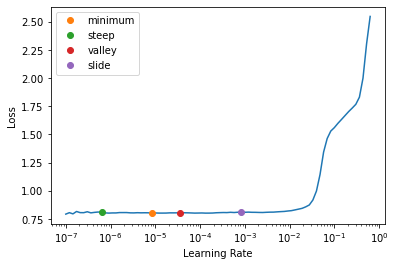

In [434]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [435]:
lr = lrs.slide
learn.fit_one_cycle(5, lr_max=slice(lr/10, lr))
learn.save("AZ_TMNIST_KaggleA_Adam_ep10")

epoch,train_loss,valid_loss,accuracy,time
0,0.832674,0.792543,0.967690,05:42
1,0.833426,0.779722,0.971743,05:28
2,0.798860,0.761932,0.974649,05:29
3,0.786865,0.748617,0.976676,05:45
4,0.773154,0.745129,0.977517,05:40


Path('models/AZ_TMNIST_KaggleA_Adam_ep10.pth')

There isn't much change in accuracy, but let's still try.

SuggestedLRs(minimum=1.584893179824576e-05, steep=3.311311274956097e-06, valley=0.00010964782268274575, slide=0.0012022644514217973)

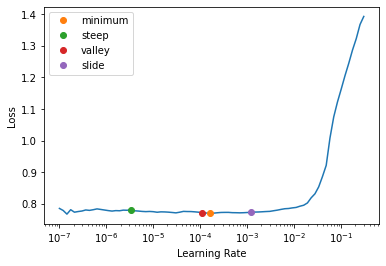

In [437]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

Just to see if there's any difference, let's try with a flat LR and train a bit longer. We are getting some accuracy gains, but 0.980767 is good enough for now.

In [65]:
lr = lrs.slide
learn.fit_one_cycle(10, lr)
learn.save("AZ_TMNIST_KaggleA_Adam_ep20")

AttributeError: 'NoneType' object has no attribute 'fit_one_cycle'

### Kaggle CNN A with A–Z

Let's try with Kaggle learner A, with 807,162 params. Note that the original author used RMSProp.

In the end we got to about 0.975 in ~12 epochs.

WARN! Need to add custom normalisation scheme and check this doesn't expand channels!
Warning! Undersampled to max 2240 items / category, using 56043 items of 372450.


SuggestedLRs(minimum=0.04365158379077912, steep=1.9054607152938843, valley=0.0005754399462603033, slide=0.0014454397605732083)

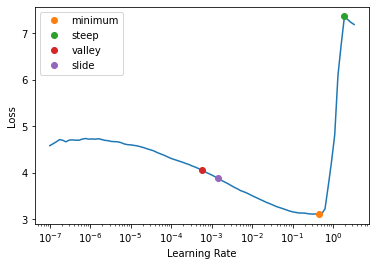

In [381]:
learn = get_ocr_learner_2(bs=128)
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

In [384]:
learn.fit_one_cycle(5, lrs.valley)
learn.save("AZ_KaggleA_Adam_ep5")

epoch,train_loss,valid_loss,accuracy,time
0,1.427275,1.147221,0.863847,01:30
1,1.073666,0.955968,0.931656,01:30
2,0.950433,0.877948,0.954764,01:25
3,0.899174,0.837020,0.964400,01:25
4,0.887624,0.828624,0.966096,01:25


Path('models/AZ_KaggleA_Adam_ep5.pth')

SuggestedLRs(minimum=1.737800812406931e-06, steep=1.0964781722577754e-06, valley=3.981071586167673e-06, slide=0.0003311311302240938)

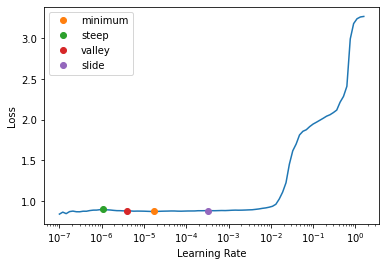

In [385]:
lrs_ep5 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs_ep5

In [386]:
lr = lrs_ep5.valley
learn.fit_one_cycle(10, lr_max=slice(lr/50, lr))
learn.save("AZ_KaggleA_Adam_ep15")

epoch,train_loss,valid_loss,accuracy,time
0,0.887532,0.828507,0.966453,01:26
1,0.889081,0.827440,0.967345,01:23
2,0.887363,0.826695,0.967077,01:26
3,0.882653,0.825991,0.966899,01:26
4,0.882872,0.825622,0.966988,01:25
5,0.884416,0.825499,0.967434,01:24
6,0.881002,0.825093,0.967077,01:25
7,0.880805,0.825239,0.967434,01:25
8,0.881626,0.824835,0.967523,01:23
9,0.888233,0.825037,0.967166,01:23


Path('models/AZ_KaggleA_Adam_ep15.pth')

The lr was obviously too low, so let's pick a higher one.

In [387]:
lr = lrs_ep5.slide
learn.fit_one_cycle(10, lr_max=slice(lr/50, lr))
learn.save("AZ_KaggleA_Adam_ep25")

epoch,train_loss,valid_loss,accuracy,time
0,0.888399,0.830050,0.963419,01:22
1,0.897186,0.832146,0.963687,01:22
2,0.884049,0.815374,0.968594,01:22
3,0.859040,0.811283,0.966720,01:24
4,0.852477,0.796069,0.970914,01:26
5,0.842758,0.788758,0.972163,01:22
6,0.840113,0.784477,0.973590,01:27
7,0.821083,0.776635,0.974661,01:19
8,0.810697,0.774374,0.974929,01:17
9,0.818089,0.773496,0.975286,01:17


Path('models/AZ_KaggleA_Adam_ep25.pth')

This is pretty good but much less than our example of 99.9% accuracy. That seems the be calculated on the imbalanced dataset without smoothing, so it might be skewed. Let's train more.

SuggestedLRs(minimum=6.30957365501672e-06, steep=1.5848931980144698e-06, valley=4.365158383734524e-05, slide=0.010964781977236271)

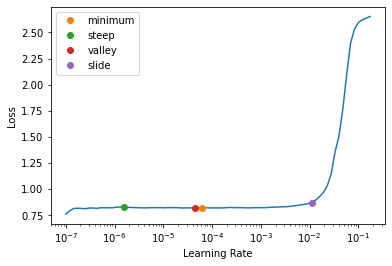

In [388]:
lrs_ep25 = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs_ep25

We can keep the learning rate same as with the previous.

In [394]:
learn.load("AZ_KaggleA_Adam_ep25")
lr = lrs_ep5.slide
learn.fit_one_cycle(10, lr_max=slice(lr/50, lr))
learn.save("AZ_KaggleA_Adam_ep35")

epoch,train_loss,valid_loss,accuracy,time
0,0.819499,0.778946,0.975107,01:43
1,0.838656,0.789813,0.971717,01:32
2,0.835209,0.784419,0.971717,01:41
3,0.832525,0.781969,0.971717,01:37
4,0.824483,0.778975,0.973680,01:36
5,0.812837,0.772739,0.974393,01:37
6,0.809515,0.767931,0.978051,01:41
7,0.798968,0.760776,0.976535,01:28
8,0.797000,0.759097,0.978051,01:32
9,0.791847,0.758594,0.978051,01:35


Path('models/AZ_KaggleA_Adam_ep35.pth')

### First Resnet type attempts

In [166]:
#export

def create_nist_learner(path = NIST_PATH, model_path = MODELS_PATH, vocab = None,
                        cut = 5, size = 128) -> Learner:

    enable_global_greyscale()

    fnames = get_nist_images(vocab=vocab, 
                             path=path,
                             show_stats=False)
    tfms = aug_transforms(mult=1.0, do_flip=False, flip_vert=False, max_rotate=5.0, 
                          min_zoom=0.85, max_zoom=1.15, max_warp=0.1, p_affine=.5, 
                          p_lighting=0., xtra_tfms=None, size=size, mode='bilinear', 
                          pad_mode='reflection', align_corners=True, batch=False, 
                          min_scale=1.0)
    del(tfms[1]) # Remove lighting tfm
    print("WARN! Need to add custom normalisation scheme and check this doesn't expand channels!")
    # Normalize.from_stats(mean,std)
    # https://docs.fast.ai/data.transforms.html#Normalize
    # X_train_mean = X_train.mean().astype(np.float32)
    # X_train_std = X_train.std().astype(np.float32)
    # X_test_mean = X_test.mean().astype(np.float32)
    # X_test_std = X_test.std().astype(np.float32)

    # X_train = (X_train - X_train_mean)/X_train_std
    # X_test = (X_test - X_test_mean)/X_test_std
    dls = ImageDataLoaders.from_name_func(path, fnames, nist_from_name_func, 
                                          num_workers=0,   # Needed for Mac
                                          valid_pct=0.2, 
                                          batch_tfms=tfms, # This raises if used as item_tfms
                                          seed=42)


    
    learn = cnn_learner(dls, resnet18, 
                        n_in=1,
                        normalize=False, # ImageNet norm makes image 3-channel
                        path=".", 
                        model_dir=model_path, 
                        loss_func=CrossEntropyLossFlat(), 
                        metrics=accuracy,
                        cut=cut)
    return learn

Let's create a NIST model now for testing. With cut=5 and size=128, the performance was not stellar.

Let's try one with no cut and downsize inputs for testing.

In [169]:
# learn = create_nist_learner(cut = 5, size = 128)
# learn.load("OCR_NIST_resnet18_ep3")

learn.summary()

WARNING! Enabling global grayscale behaviour for PILImages! To undo, call disable_global_greyscale.
Warning! Undersampled to max 3840 items / category, using 212372 items of 731668.


Sequential (Input shape: 64 x 1 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 32 x 32   
Conv2d                                    3136       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 16 x 16   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                        

In [175]:
learn = None
gc.collect()

583126

### Previous Results

Cut=6, size=64, 841,152 params, accuracy after 1 epoch at lr 1e-2 is 0.673612

Note that the model is frozen, even though it's not pretrained, which is quite strange... Let's unfreeze the model and plot LR again. (Well, the plot is very similar to the previous one.)

SuggestedLRs(minimum=0.005754399299621582, steep=0.033113110810518265, valley=0.0006918309954926372, slide=0.001737800776027143)

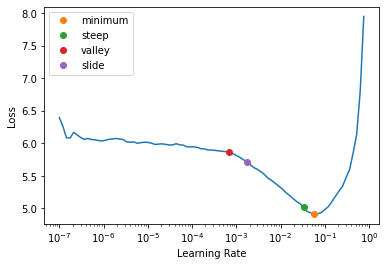

In [170]:
learn = create_nist_learner(cut = 6, size = 128 // 2)
learn.unfreeze()
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
lrs

epoch,train_loss,valid_loss,accuracy,time
0,0.821686,0.917308,0.673612,2:09:09
1,0.611677,0.503927,0.790460,58:27
2,0.503300,0.445421,0.821915,39:39


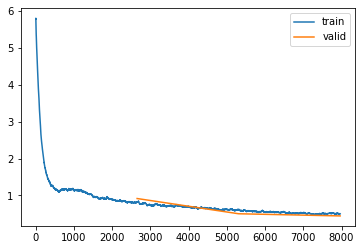

In [171]:
learn.fit_one_cycle(3, 1e-2)
learn.save("OCR_NIST_resnet18_cut6_size62_ep3")
learn.recorder.plot_loss()

For cut=5, size=128, accuracy after 3 epochs at lr 1e-2 is 0.801573

epoch,train_loss,valid_loss,accuracy,time
0,0.849524,2.152726,0.380444,1:27:59
1,0.668341,0.670599,0.725832,1:23:16
2,0.545992,0.475553,0.801573,1:22:36


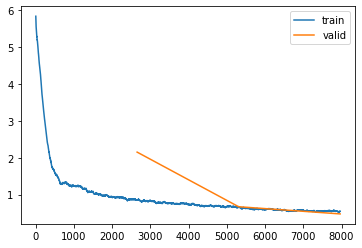

In [151]:
learn.fit_one_cycle(3, 1e-2)
# learn.save("OCR_NIST_resnet18_ep3")
learn.recorder.plot_loss()

In [59]:
#hide

# It would be nice to have an oversampling method ready, but the code below is for Fast.ai v1
# and would have to be converted to probably something tied to the DataLoader.

from torch.utils.data.sampler import WeightedRandomSampler

class OverSamplingCallback(Callback):
    """Oversampling to correct unbalanced dataset.
       By Tanishq Mathew Abraham, https://www.kaggle.com/code/tanlikesmath/oversampling-mnist-with-fastai/notebook"""
    def __init__(self,learn:Learner):
        super().__init__(learn)
        ds = self.learn.data.train_dl.dataset
        self.labels = ds.y.items
        _, counts = np.unique(self.labels, return_counts=True)
        self.weights = torch.DoubleTensor((1/counts)[self.labels])
        self.label_counts = np.bincount([self.learn.data.train_dl.dataset.y[i].data \
                                         for i in range(len(ds))])
        self.total_len_oversample = int(self.learn.data.c * np.max(self.label_counts))
        
    def before_train(self, **kwargs):
        self.learn.data.train_dl.dl.batch_sampler = BatchSampler(WeightedRandomSampler(self.weights, self.total_len_oversample), 
                                                                 self.learn.data.train_dl.batch_size,
                                                                 False)

## Older Models

In [45]:
#export

def create_ocr_model(epochs=1, save_as = "OCR_resnet18_wip", 
                     load_from: str = None, cut: int = None,
                     resize: int = None) -> Learner:
    """Create a simple resnet18-based OCR model cut at `cut` with images 
       optionally resized to `resize` and fine-tuning for `epochs`, 
       or load one from `load_from`."""
    path = GOOGLE_FONT_PATH
    model_path = "models"
    fnames = get_image_files(path)
    pat = r"^([^_]+)_.+$"
    for f in fnames: assert re.search(pat, str(f)) is not None

    dls = ImageDataLoaders.from_name_re(path, fnames, pat, 
                                        num_workers=0, # NEEDED FOR MAC!
                                        valid_pct=0.2, 
                                        item_tfms=Resize(resize, method=ResizeMethod.Squish) if resize is not None else None,
                                        seed=42)
    learn = cnn_learner(dls, resnet18, 
                        path=".", 
                        model_dir=model_path, 
                        loss_func=F.cross_entropy, 
                        metrics=accuracy,
                        cut=cut)

    if load_from is not None: 
        learn.load(load_from)
    elif epochs is not None:
        learn.fine_tune(epochs)
        learn.save(save_as)

    return learn

def get_ocr_model(cut: int = None, img_size: int = None) -> Learner:
    """Get a basic pretrained ocr model cut at `cut` and with input 
       at `img_size`."""
    file = "OCR_resnet18"
    if cut is not None: file += f"_cut{cut}"
    if img_size is not None: file += f"_imgsize{img_size}"
    return create_ocr_model(load_from=file, cut=cut, resize=img_size)

Create OCR learner versions with different body-head cuts. Cut 8 equals the default with parameter numbers as follows:

|Cut     | Total params | Trainable  |
|-------:|-------------:|-----------:|
| 5      |      237,632 |     80,768 |
| 6      |      828,992 |    147,840 |
| 7      |    3,060,288 |    281,984 |
| 8/None |   11,717,184 |    550,272 |

In [33]:
def create_ocr_models():
    # This uses a silly way of setting epochs
    # Todo: convert to one fine_tune call and add a callback to save model 
    # afte each epoch
    for cut in range(5, 8):
        epochs = 1 + (9 - cut) * 2
        save_as = f"OCR_resnet18_cut_{cut}_ep_"
        print(f"Generating {save_as}")
        create_ocr_model(epochs=epochs, 
                        cut=cut,
                        save_as=save_as)

Generating OCR_resnet18_cut_5_ep_


epoch,train_loss,valid_loss,accuracy,time
0,1.605312,0.484268,0.867357,12:59


epoch,train_loss,valid_loss,accuracy,time
0,0.716697,0.353588,0.908749,16:04


epoch,train_loss,valid_loss,accuracy,time
0,0.566932,0.291424,0.922389,11:52


epoch,train_loss,valid_loss,accuracy,time
0,0.460128,0.259752,0.931326,18:02


epoch,train_loss,valid_loss,accuracy,time
0,0.449595,0.255861,0.935089,13:07


epoch,train_loss,valid_loss,accuracy,time
0,0.382626,0.224435,0.947319,16:06


epoch,train_loss,valid_loss,accuracy,time
0,0.363155,0.214040,0.945437,12:05


epoch,train_loss,valid_loss,accuracy,time
0,0.306389,0.199166,0.952963,16:50


epoch,train_loss,valid_loss,accuracy,time
0,0.303421,0.205631,0.948260,11:46


epoch,train_loss,valid_loss,accuracy,time
0,0.266260,0.186818,0.952023,15:56


epoch,train_loss,valid_loss,accuracy,time
0,0.276060,0.184563,0.951552,11:44


epoch,train_loss,valid_loss,accuracy,time
0,0.245104,0.167335,0.960960,15:58


epoch,train_loss,valid_loss,accuracy,time
0,0.249963,0.187017,0.954374,11:47


epoch,train_loss,valid_loss,accuracy,time
0,0.232916,0.160296,0.956726,15:56


epoch,train_loss,valid_loss,accuracy,time
0,0.242837,0.180903,0.956726,11:47


epoch,train_loss,valid_loss,accuracy,time
0,0.216217,0.150158,0.961900,16:19


epoch,train_loss,valid_loss,accuracy,time
0,0.217640,0.156174,0.959078,11:42


epoch,train_loss,valid_loss,accuracy,time
0,0.197112,0.148186,0.964252,16:00


Generating OCR_resnet18_cut_6_ep_


epoch,train_loss,valid_loss,accuracy,time
0,1.340487,0.304608,0.927563,17:37


epoch,train_loss,valid_loss,accuracy,time
0,0.403672,0.209140,0.951552,24:15


epoch,train_loss,valid_loss,accuracy,time
0,0.343246,0.172163,0.960960,17:37


epoch,train_loss,valid_loss,accuracy,time
0,0.222726,0.148525,0.965193,24:20


epoch,train_loss,valid_loss,accuracy,time
0,0.199566,0.143396,0.966604,17:37


epoch,train_loss,valid_loss,accuracy,time
0,0.183443,0.120399,0.972719,24:16


epoch,train_loss,valid_loss,accuracy,time
0,0.164150,0.128926,0.969426,17:38


epoch,train_loss,valid_loss,accuracy,time
0,0.130288,0.109580,0.973189,24:14


epoch,train_loss,valid_loss,accuracy,time
0,0.136742,0.104211,0.975071,17:37


epoch,train_loss,valid_loss,accuracy,time
0,0.110741,0.101772,0.975071,24:15


epoch,train_loss,valid_loss,accuracy,time
0,0.102026,0.108892,0.973659,17:38


epoch,train_loss,valid_loss,accuracy,time
0,0.074477,0.093923,0.977422,24:18


epoch,train_loss,valid_loss,accuracy,time
0,0.094133,0.099922,0.975541,17:37


epoch,train_loss,valid_loss,accuracy,time
0,0.071028,0.088766,0.977422,24:10


Generating OCR_resnet18_cut_7_ep_


epoch,train_loss,valid_loss,accuracy,time
0,0.824907,0.128713,0.967074,22:46


epoch,train_loss,valid_loss,accuracy,time
0,0.136488,0.066519,0.983537,31:41


epoch,train_loss,valid_loss,accuracy,time
0,0.090889,0.060237,0.985419,22:46


epoch,train_loss,valid_loss,accuracy,time
0,0.053797,0.052439,0.986830,31:42


epoch,train_loss,valid_loss,accuracy,time
0,0.045052,0.056773,0.985889,22:52


epoch,train_loss,valid_loss,accuracy,time
0,0.035270,0.042861,0.989182,31:51


epoch,train_loss,valid_loss,accuracy,time
0,0.021533,0.051969,0.985889,22:47


epoch,train_loss,valid_loss,accuracy,time
0,0.022024,0.039496,0.989652,31:46


epoch,train_loss,valid_loss,accuracy,time
0,0.017432,0.051527,0.986830,1:00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.018832,0.040182,0.990593,36:13


In [10]:
learn = get_ocr_model()
dls = learn.dls
img,y = dls.train.dataset[0]
batch,_ = dls.train.one_batch()
res = learn.predict(img)
y_1h = F.one_hot(y, num_classes=dls.c).float()
pred = res[1]
pred.requires_grad_()
inp = torch.reshape(pred, (1, -1))
tar = torch.reshape(y, (-1,))
print(inp.shape, tar.shape, tar)
F.cross_entropy(inp, tar)

torch.Size([1, 26]) torch.Size([1]) TensorCategory([17])


TensorCategory(8.3446e-07, grad_fn=<AliasBackward0>)

## Export

In [21]:
#hide
from nbdev.export import notebook2script; notebook2script()

Converted 01_fontlearnertests.ipynb.
Converted 02_first_letter_and_optim_tests.ipynb.
Converted 03_vector_models.ipynb.
Converted 04_font_statistics.ipynb.
Converted 05_full_aphabet_optimisation.ipynb.
Converted 06_data_augmentation.ipynb.
Converted 07_optimising_with_augmentation.ipynb.
Converted 08_comparing_existing_fonts.ipynb.
Converted 09_optimise_to_match_font.ipynb.
Converted 10_optimising_with_aug_run_2.ipynb.
Converted 11_optimise_to_match_font_multires.ipynb.
Converted 12_optimising_with_aug_with_multiple_ocr_models.ipynb.
Converted 13_analysing_ocr_models.ipynb.
Converted aifont_core.ipynb.
Converted aifont_fontlearner.ipynb.
Converted aifont_fontsampler.ipynb.
Converted aifont_ocrlearner.ipynb.
Converted index.ipynb.
